In [ ]:
%pip install transformers 
%pip install datasets 
%pip install scikit-learn
%pip install torch
%pip install datasets
%pip install accelerate

## Step 0: Install and Import Required Libraries

This notebook uses the Gemini 1.5 model via the Google Generative Language API.  
We use the official `google.generativeai` SDK to make API calls.

Make sure you have enabled access to Gemini in your Google Cloud project and obtained an API key from [Google AI Studio](https://makersuite.google.com/app).


In [ ]:
%pip install google-genai

In [2]:
from google import genai
import pandas as pd
import numpy as np
import tiktoken
import time
from tqdm import tqdm
import matplotlib.pyplot as plt



/Users/dimitriroulin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# Please install OpenAI SDK first: `pip3 install openai`

from openai import OpenAI

client = OpenAI(api_key="", base_url="https://api.deepseek.com")

response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": "Hello"},
    ],
    stream=False
)

print(response.choices[0].message.content)

Hello! How can I assist you today? 😊


### Step 1: Load Dataset

In this step, we load the dataset containing CEFR-labeled sentences used for model evaluation.

- `train_data.csv`: Contains the training portion of the dataset.
- `test_data.csv`: Contains the test portion for evaluating zero-shot and fine-tuned models.
- Each dataset is assumed to have at least the following columns:
  - `sentence`: The text to classify.
  - `difficulty_label`: The true CEFR level (e.g., A1, A2, B1, ..., C2).

This split will allow us to run consistent evaluations across model variants.


In [7]:
train_data = pd.read_csv("./Data/train_data.csv")
test_data = pd.read_csv("./Data/test_data.csv")

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
# Display the first few rows of the training data
print("Training data:")
display(train_data.head())
print("Test data:")
display(test_data.head())

Train size: 2817
Test size: 705
Training data:


,sentence,difficulty,text_id,sentence_length,sentence_tokens,total_tokens_per_call,difficulty_reviewed,readability,difficulty_label
0,Zur Vorbereitung sollte man mit einem Arm eine...,3,306,19,27.0,139.0,B2,69.11,B2
1,Es ist ein sehr schöner Abend.,0,531,6,NaN,NaN,A1,99.23,A1
2,Heute führt die Route durch das Gaistal.,1,476,7,10.0,115.0,A2,115.13,A2
3,Als besser verträglich mit dem Leitbild der na...,5,unknown,14,NaN,NaN,C2,31.89,C2
4,Hierzulande liegen sie im Schnitt bei 15. 000 ...,2,483,9,15.0,121.0,B1,87.72,B1


Test data:


,sentence,difficulty,text_id,sentence_length,sentence_tokens,total_tokens_per_call,difficulty_reviewed,readability,difficulty_label
0,Es steht an gefährlichen Kreuzungen oder Einmü...,3,638,13,NaN,NaN,B2,49.82,B2
1,1988 entstand in den USA die „International Da...,4,283,24,43.0,150.0,C1,38.66,C1
2,"Die Denkweise, Häuser als Maschinen, in denen ...",5,unknown,24,NaN,NaN,C2,67.76,C2
3,Architekten können heute keine Bauwerke mehr s...,5,unknown,22,NaN,NaN,C2,57.61,C2
4,60 Prozent verwenden das Taschengeld auch für ...,2,654,10,NaN,NaN,B1,86.71,B1


### Step 2: Define CEFR Classification Function using Gemini 1.5 (Zero‑Shot)

This function sends a CEFR classification prompt to the Gemini 1.5 model (`gemini-2.0-pro` or `gemini-2.0-flash`) using the same instruction format as in the OpenAI experiments.

The prompt strictly instructs the model to return one of: A1, A2, B1, B2, C1, or C2 — without explanation.


In [18]:
# Few-shot examples block (same format as final query)
fewshot_block = """
Text: "Tim sieht auf den Spielplan."
A1

Text: "Jetzt bin ich bereit, Berlin zu erkunden."
A2

Text: "Nach der Werkstatt übernimmt der Kollege die Fahrzeuge."
B1

Text: "Es ist ein Symbol für die zukunftsträchtige Freundschaft zwischen Deutschland und China!"
B2

Text: "All das macht aus seinen Schriften ein einmaliges Dokument der Entstehung des modernen Denkens."
C1

Text: "Da Ochsen auch als dumm galten, entwickelte sich wahrscheinlich so die Idee, dass ein Brett vor dem Kopf das Denken behindert."
C2
"""

def build_cefr_prompt_few_shot(sentence: str) -> str:
    return f"""
You are a language assessor using the Common European Framework of Reference for Languages (CEFR).
Your task is to assign a language proficiency score to this text, using the CEFR levels from A1 (beginner) to C2 (advanced/native). 
Evaluate the given text and **ONLY** return one of the following levels: A1, A2, B1, B2, C1, or C2.
Do not provide any explanation or additional text. Just return the level.

{fewshot_block}

Text: "{sentence}"
"""



# Function to call Gemini
def classify_with_deepseek_few_shots(sentence: str, model: str = "deepseek-chat") -> str:
    prompt = build_cefr_prompt_few_shot(sentence)
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a CEFR language proficiency classifier."},
                {"role": "user", "content": prompt},
            ],
            temperature=0,
            max_tokens=2,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"API call failed for DeepSeek: {e}")
        return None




# Define the prompt template
def build_cefr_prompt_zero_shot(sentence: str) -> str:
    return f"""
You are a language assessor using the Common European Framework of Reference for Languages (CEFR).
Your task is to assign a language proficiency score to this text, using the CEFR levels from A1 (beginner) to C2 (advanced/native). 
Evaluate the given text and **ONLY** return one of the following levels: A1, A2, B1, B2, C1, or C2.
Do not provide any explanation or additional text. Just return the level.

Text: "{sentence}"
"""

# Function to call Gemini
def classify_with_deepseek_zero_shot(sentence: str, model: str = "deepseek-chat") -> str:
    prompt = build_cefr_prompt_zero_shot(sentence)
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a CEFR language proficiency classifier."},
                {"role": "user", "content": prompt},
            ],
            temperature=0,
            max_tokens=2,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"API call failed for DeepSeek: {e}")
        return None


Here you can ensure that you set up correctly your api key.

In [19]:
print(classify_with_deepseek_zero_shot("Ich liebe es, am Wochenende spazieren zu gehen."))
print(classify_with_deepseek_few_shots("Ich liebe es, am Wochenende spazieren zu gehen."))


A2
A2


### Step 3: Estimate Cost per Model (based on character count)

Gemini models are billed by characters, not tokens.  
We estimate the input size based on prompt length, and assume a short fixed-size output (e.g., 3–5 characters per CEFR label).


In [ ]:
# Pricing per 1,000 characters

GEMINI_PRICING = {
    #"gemini-2.0-pro":   {"input": 0.000125, "output": 0.000375},  # still valid
    "gemini-2.0-flash": {"input": 0.0000375, "output": 0.00015}   # updated from $/M char
}

# Estimate cost from character counts
def estimate_gemini_cost(input_chars: int, output_chars: int, model: str) -> float:
    price = GEMINI_PRICING.get(model, GEMINI_PRICING["gemini-2.0-pro"])
    cost_input  = (input_chars  / 1000) * price["input"]
    cost_output = (output_chars / 1000) * price["output"]
    return round(cost_input + cost_output, 6) 


In [ ]:
# ----------------------------
# Configuration
# ----------------------------
models = ["gemini-2.0-flash"]
assumed_output_chars_per_response = 2
total_output_chars = assumed_output_chars_per_response * len(test_data)

# Updated pricing (per 1,000 characters)
GEMINI_PRICING = {
    "gemini-2.0-pro":   {"input": 0.000125,  "output": 0.000375},
    "gemini-2.0-flash": {"input": 0.0000375, "output": 0.00015}
}

# ----------------------------
# Few-shot exemplars (same for all)
# ----------------------------
fewshot_block = """
Text: "Tim sieht auf den Spielplan."
A1

Text: "Jetzt bin ich bereit, Berlin zu erkunden."
A2

Text: "Nach der Werkstatt übernimmt der Kollege die Fahrzeuge."
B1

Text: "Es ist ein Symbol für die zukunftsträchtige Freundschaft zwischen Deutschland und China!"
B2

Text: "All das macht aus seinen Schriften ein einmaliges Dokument der Entstehung des modernen Denkens."
C1

Text: "Da Ochsen auch als dumm galten, entwickelte sich wahrscheinlich so die Idee, dass ein Brett vor dem Kopf das Denken behindert."
C2
"""

# ----------------------------
# Cost results structure
# ----------------------------
results = {
    "Metric": ["Total input characters", "Total output characters", "Estimated cost (USD)"]
}

# ----------------------------
# Compute per model
# ----------------------------
for model in models:
    total_input_chars = 0

    for sentence in tqdm(test_data["sentence"], desc=f"Processing {model}"):
        prompt = f"""
You are a language assessor using the Common European Framework of Reference for Languages (CEFR).
Your task is to assign a language proficiency score to this text, using the CEFR levels from A1 (beginner) to C2 (advanced/native). 
Evaluate the given text and **ONLY** return one of the following levels: A1, A2, B1, B2, C1, or C2.
Do not provide any explanation or additional text. Just return the level.

Text: "{sentence}"
"""
        total_input_chars += len(prompt)

    price = GEMINI_PRICING[model]
    input_cost  = (total_input_chars / 1000) * price["input"]
    output_cost = (total_output_chars  / 1000) * price["output"]
    total_cost  = input_cost + output_cost

    results[model] = [
        f"{total_input_chars:,}",
        f"{total_output_chars:,}",
        f"${total_cost:,.4f}"
    ]

# ----------------------------
# Display table
# ----------------------------
df_costs = pd.DataFrame(results).set_index("Metric")

# Plotting the table
fig, ax = plt.subplots(figsize=(9, 2.5))
ax.axis("off")

table = ax.table(
    cellText=df_costs.values,
    rowLabels=df_costs.index,
    colLabels=df_costs.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(2, 1.5)

plt.title("Comparison of Character Usage and Inference Cost per Gemini Model (ZERO SHOTS)", fontsize=12, pad=20)
plt.tight_layout()
plt.show()


### Step 4: Run Gemini Predictions and Save Results

This step applies the Gemini CEFR classifier to each sentence in the test dataset.  
The predictions are stored in a new column and saved for later evaluation.


In [23]:
# Choose the model: "gemini-2.0-pro" or "gemini-2.0-flash"
selected_model = "deepseek-v3_few_shots"  # or "gemini-2.0-pro"
output_column = f"prediction_{selected_model.replace('.', '-')}"  # avoid dots in column name

# Create a copy to avoid modifying the original
test_deepseek = test_data.copy()
test_deepseek[output_column] = None

# Run predictions with progress bar
for i, row in tqdm(test_deepseek.iterrows(), total=len(test_deepseek), desc=f"Classifying with {selected_model}"):
    sentence = row["sentence"]
    prediction = classify_with_deepseek_few_shots(sentence)
    test_deepseek.at[i, output_column] = prediction
    time.sleep(0.2)  # optional: throttle to avoid quota issues

    

# Save the predictions
save_path = f"./Data/Predictions/Deepseek/predictions_{selected_model.replace('.', '-')}.csv"
test_deepseek.to_csv(save_path, index=False)
print(f"✅ Predictions saved to: {save_path}")


Classifying with deepseek-v3_few_shots: 100%|██████████| 705/705 [54:37<00:00,  4.65s/it]  

✅ Predictions saved to: ./Data/Predictions/Deepseek/predictions_deepseek-v3_few_shots.csv


### 5. Evaluation

#### Step 5.1: Load and Aggregate Gemini Model Predictions

We now load all predictions produced by Gemini 1.5 (Pro and Flash) and merge them into a single DataFrame for evaluation.

Each CSV must include the columns:  
- `sentence`  
- `difficulty_label`  
- `prediction_<model_name>`


In [24]:
import os
import pandas as pd

# Folder where Deepseek predictions are stored
prediction_folder = "./Data/Predictions/Deepseek"

# Initialize empty structure
combined_df = None

# Load and merge all CSVs
for file in os.listdir(prediction_folder):
    if file.endswith(".csv") and file.startswith("predictions_"):
        model_name = file.replace("predictions_", "").replace(".csv", "")
        path = os.path.join(prediction_folder, file)

        df = pd.read_csv(path)
        df = df[["sentence", "difficulty_reviewed", f"prediction_{model_name}"]]

        if combined_df is None:
            combined_df = df
        else:
            combined_df = pd.merge(combined_df, df, on=["sentence", "difficulty_reviewed"], how="inner")

# Display summary
print(f"✅ Loaded predictions from {len(combined_df.columns) - 2} Deepseek models.")
combined_df.head()



✅ Loaded predictions from 2 Deepseek models.


,sentence,difficulty_reviewed,prediction_deepseek-v3_zero_shot,prediction_deepseek-v3_few_shots
0,Es steht an gefährlichen Kreuzungen oder Einmü...,B2,B1,B1
1,1988 entstand in den USA die „International Da...,C1,B2,B2
2,"Die Denkweise, Häuser als Maschinen, in denen ...",C2,C1,C1
3,Architekten können heute keine Bauwerke mehr s...,C2,B2,C1
4,60 Prozent verwenden das Taschengeld auch für ...,B1,B1,A2


#### Step 5.2: Accuracy, Macro-F1, and Per-Class Metrics for Gemini Models

We compute standard evaluation metrics for each Gemini model:
- Accuracy
- Macro-averaged F1 score
- Full per-class precision/recall/F1 table


In [26]:
from sklearn.metrics import accuracy_score, classification_report

label_order = ["A1", "A2", "B1", "B2", "C1", "C2"]

# Summary container
summary_rows = []
per_class_frames = []

for col in combined_df.columns:
    if col.startswith("prediction_"):
        model = col.replace("prediction_", "")
        y_true = combined_df["difficulty_reviewed"]
        y_pred = combined_df[col]

        # Drop invalid or missing predictions
        mask = y_pred.isin(label_order)
        y_true = y_true[mask]
        y_pred = y_pred[mask]

        # Compute classification report
        report = classification_report(
            y_true,
            y_pred,
            labels=label_order,
            target_names=label_order,
            output_dict=True,
            zero_division=0
        )

        # Add overall summary row
        summary_rows.append({
            "Model": model,
            "Accuracy": round(accuracy_score(y_true, y_pred), 4),
            "Macro-F1": round(report["macro avg"]["f1-score"], 4)
        })

        # Store per-class breakdown
        class_df = (
            pd.DataFrame(report).T
              .drop(index=["macro avg", "weighted avg"])
              .assign(Model=model)
              .set_index("Model", append=True)
        )
        per_class_frames.append(class_df)

# Combine overall scores
df_metrics = (
    pd.DataFrame(summary_rows)
      .sort_values("Macro-F1", ascending=False)
      .reset_index(drop=True)
)

# Combine per-class metrics
df_per_class = (
    pd.concat(per_class_frames)
      .rename_axis(index=["Class", "Model"])
)

# Display
print("Overall Accuracy & Macro-F1")
display(df_metrics)

print("Per-Class Metrics")
display(df_per_class)


Overall Accuracy & Macro-F1


,Model,Accuracy,Macro-F1
0,deepseek-v3_few_shots,0.4965,0.4775
1,deepseek-v3_zero_shot,0.3362,0.2781


Per-Class Metrics


,,precision,recall,f1-score,support
Class,Model,,,,
A1,deepseek-v3_zero_shot,0.880000,0.188034,0.309859,117.000000
A2,deepseek-v3_zero_shot,0.356061,0.401709,0.377510,117.000000
B1,deepseek-v3_zero_shot,0.409091,0.915254,0.565445,118.000000
B2,deepseek-v3_zero_shot,0.213974,0.415254,0.282421,118.000000
C1,deepseek-v3_zero_shot,0.185185,0.084746,0.116279,118.000000
C2,deepseek-v3_zero_shot,1.000000,0.008547,0.016949,117.000000
accuracy,deepseek-v3_zero_shot,0.336170,0.336170,0.336170,0.336170
A1,deepseek-v3_few_shots,0.822917,0.675214,0.741784,117.000000
A2,deepseek-v3_few_shots,0.591837,0.495726,0.539535,117.000000


## Step 5.3: Confusion Matrix for Gemini Predictions

We generate confusion matrices for each model to understand where CEFR level misclassifications occur.

Only valid predictions (`A1`–`C2`) are included.


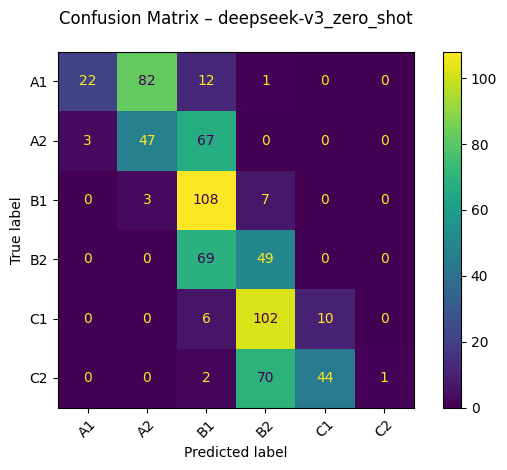

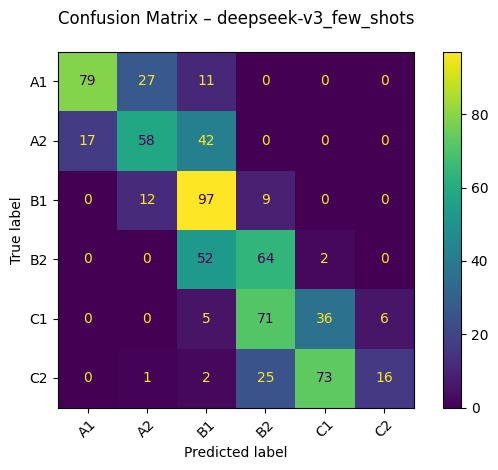

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# CEFR label mapping
label_order = ["A1", "A2", "B1", "B2", "C1", "C2"]
label_to_idx = {lbl: i for i, lbl in enumerate(label_order)}

def plot_confusion(model_name, drop_invalid=True):
    pred_col = f"prediction_{model_name}"
    if pred_col not in combined_df.columns:
        raise ValueError(f"No predictions found for model: {model_name}")

    y_true = combined_df["difficulty_reviewed"].astype(str).str.strip()
    y_pred = combined_df[pred_col].astype(str).str.strip()

    # Drop invalid predictions
    if drop_invalid:
        mask = y_pred.isin(label_order)
        y_true = y_true[mask]
        y_pred = y_pred[mask]

    # Map labels to integer indices
    y_true_idx = y_true.map(label_to_idx)
    y_pred_idx = y_pred.map(label_to_idx)

    cm = confusion_matrix(y_true_idx, y_pred_idx, labels=range(6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
    disp.plot(cmap="viridis")
    plt.title(f"Confusion Matrix – {model_name}", pad=20)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_confusion("deepseek-v3_zero_shot")
plot_confusion("deepseek-v3_few_shots")




## Step 5.4 – Pairwise‑Mismatch (PM)  (Henry et al., 2024)

The CEFR labels form an **ordered scale** (A1 < A2 < B1 < B2 < C1 < C2).  
Rather than counting only exact hits, Henry et al. evaluate whether the **relative
difficulty ordering** of sentences is preserved.

<img src="./Images/Pairewise-Matchinge-Explanation.png" width="800px">


In [28]:
import numpy as np

# Rank mapping for CEFR levels
rank_map = {"A1": 0, "A2": 1, "B1": 2, "B2": 3, "C1": 4, "C2": 5}

def pm_henry(y_true, y_pred):
    """Henry-style Pairwise Mismatch: divide by N (not by N choose 2)"""
    t = np.array([rank_map.get(l) for l in y_true])
    p = np.array([rank_map.get(l, np.nan) for l in y_pred])

    # Filter out invalid predictions
    mask = ~np.isnan(p)
    t, p = t[mask], p[mask]
    n = len(t)
    if n < 2:
        return np.nan

    # Compute error vectors
    v = p - t

    # All unique pairs (i < j)
    i, j = np.triu_indices(n, k=1)
    mismatch_count = (v[i] * v[j] < 0).sum()

    return round(mismatch_count / n, 2)

# Compute PM for each Gemini model
pm_scores = []
for col in combined_df.columns:
    if col.startswith("prediction_"):
        model = col.replace("prediction_", "")
        pm = pm_henry(combined_df["difficulty_reviewed"], combined_df[col])
        pm_scores.append({"Model": model, "Pairwise Mismatch": pm})

df_pm = pd.DataFrame(pm_scores).sort_values("Pairwise Mismatch").reset_index(drop=True)

# Display
print("Pairwise Mismatch Score (lower = better):")
display(df_pm)

df_merged = pd.merge(df_metrics, df_pm, on="Model")
display(df_merged)


Pairwise Mismatch Score (lower = better):


,Model,Pairwise Mismatch
0,deepseek-v3_few_shots,35.50
1,deepseek-v3_zero_shot,71.68


,Model,Accuracy,Macro-F1,Pairwise Mismatch
0,deepseek-v3_few_shots,0.4965,0.4775,35.50
1,deepseek-v3_zero_shot,0.3362,0.2781,71.68
